In [20]:
# PyTorch Workflow - end to end workflow

In [21]:
covering = {1: "data (prepare and load)",
            2: "build model",
            3: "fitting model to data(training)",
            4: "making predictions",
            5: "save + load",
            6: "put all together"}

In [22]:
import torch
from torch import nn # pytorch building blocks for nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [23]:
# Data Preparing and Loading
# Data = almost anything(excel spreadsheet, Images, Videos, Audio, DNA, Text)
# 1. Get data into numerical representation
# 2. Build a model to learn patterns in that numerical representaion

# Linear Regression to make a straight line with known parameters

In [24]:
weight = 0.7
bias = 0.3

# Create data

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [25]:
# Splitting data into training and test sets

In [26]:
# Create test/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

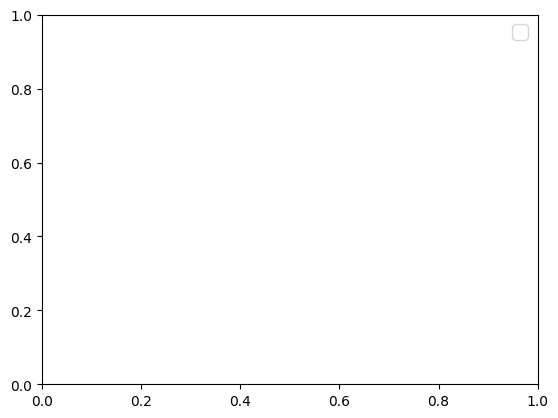

In [45]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s = 4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s = 4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s = 4, label="Predictions")

plt.legend(prop={"size":14})

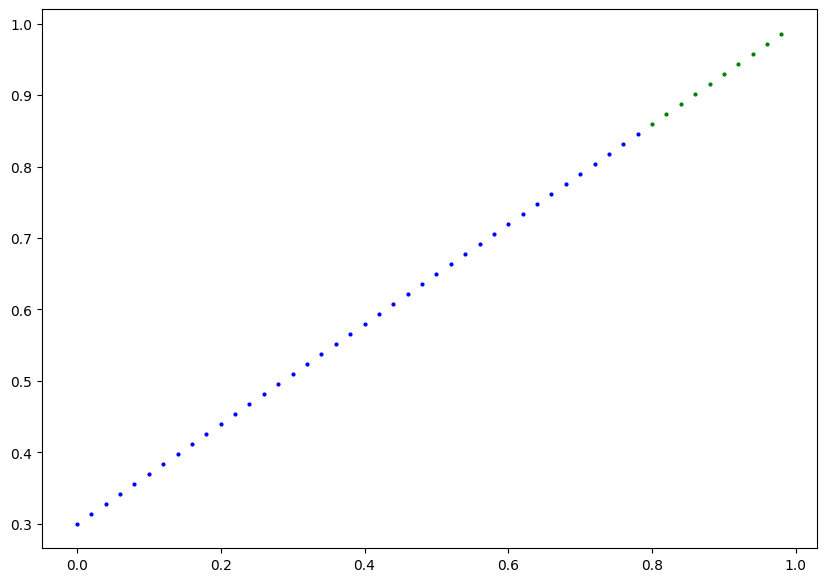

In [28]:
plot_predictions()

In [29]:
# Building a Pytorch model
# What our model does: start with random values weight and bias, look at training data and adjust the random values to get closer to the ideal values(the weight and bias values we used to create the data)
# How does it do so: 1. Gradient descent and 2. Backpropagation

In [30]:
# Create Linear Regression model class

class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computaion in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #<- "x" is the input data
    return self.weights * x + self.bias

In [31]:
# PyTorch Model building essentials
# torch.nn - contains all the building blocks for computational graphs
# torch.nn.Parameter - what params should out model try and learn
# torch.nn.Module - the base class for all nn modules, if you subclass it you should overwrite forward()
# torch.optim - optimizers in pytorch, help with gradient descent
# def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [33]:
# Checking the contents of our pytorch model
# Check our model params or check what is inside our model with .parameters()

In [36]:
# Create random seed

torch.manual_seed(1234)

# Create an instance of our model

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.0461], requires_grad=True),
 Parameter containing:
 tensor([0.4024], requires_grad=True)]

In [37]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.0461])), ('bias', tensor([0.4024]))])

In [38]:
# Making predictions using torch.inference_mode()
# To check our models predictive power lets check how it predicts x_test and y_test
# When we pass data through out model its goint through the forward method

In [39]:
with torch.inference_mode(): # context manager - inference mode turns off gradient tracking - pytorch is keeping track of less data => faster predictions
  y_preds = model_0(X_test)

y_preds

tensor([[0.4393],
        [0.4402],
        [0.4412],
        [0.4421],
        [0.4430],
        [0.4439],
        [0.4448],
        [0.4458],
        [0.4467],
        [0.4476]])

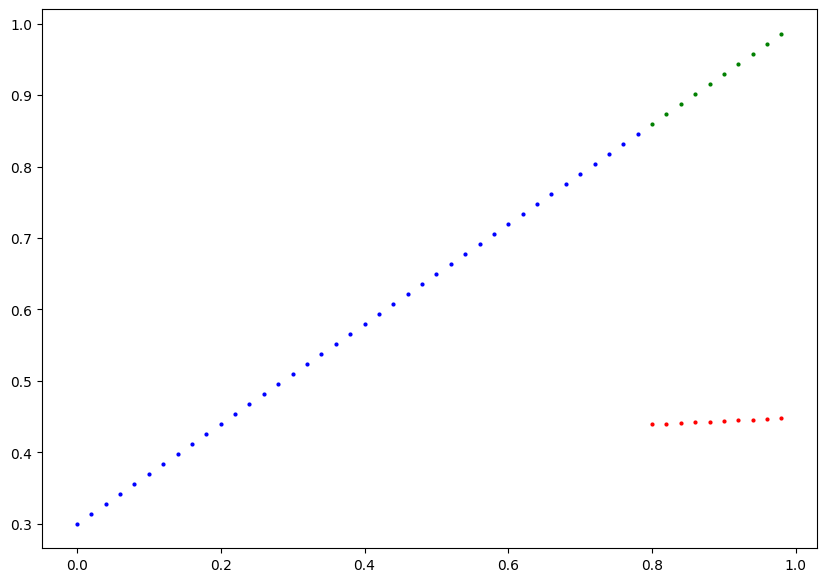

In [46]:
plot_predictions(predictions = y_preds)

In [47]:
# Training the model - the whole idea of training is to get the model to move from some random params to some known parameters
# Poor representaion -> Better representation
# One way to measure how poor or how wrong your models predictions are is to use a loss function
# Loss function may also be called cost funtion or criterion in deifferent areas
# Things we need to train:
# Loss function: A function to mesure how wrong your models predictions are compared with the ideal outputs
# Optimizer: Takes into account the loss of a model and adjusts the models parameters eg werights and bias to improve the loss function
# For pytorch we need a train loop and a testing loop

In [50]:
# Setup loss function

loss_fn = nn.L1Loss()

# Setup optimizer

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01) #lr = learning rate

In [51]:
# Building a training plus a testing loop in PyTorch
# A couple of things we need in a training loop
# 0. Loop through the data
# 1. Forward pass (this involves data moving through our models forward function) to make predictions - also called forward propagation
# 2. Calculate the loss (compare forward pass predictions to ground truth)
# 3. Optimizer zero grad
# 4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
# 5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

In [53]:
# An epoch is one loop through the data (hyperparameter because we've set them)
epochs = 10

# Training

for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer
  optimizer.step() # by default how the optimizer changes will accumulate through the loop we have to zero them above so it doesnt accumulate and start fresh each loop
  # model_0.eval() # turns off gradient tracking